# Task 3.2 : Mean squared-loss logistic regression

In our lectures we have covered using the log-likelihood loss function for logistic regression, but it is of course possible to use a wide range of loss functions. Consider for example the mean squared loss below which is common for regression tasks, but can also be applied for binary classification:

\begin{equation*}
\mathscr{L} = \frac{1}{n} \sum_{i=1}^n \frac{(y_i-\hat{y}_i)^2}{2}
\end{equation*}

In [233]:
#Importing libraries
import numpy as np
from matplotlib import pyplot as plt
from dataclasses import dataclass
from helpers import load_all_data, vectorized_flatten, sigmoid, get_mse_loss, get_accuracy, sigmoid_derivative, gradient_update, get_loss_plot, plot_loss

In [234]:
def prep_data(data_path):
    """
    Prepare data
    Use vectorized flatten
    --------------------
    return: train, validation, and test splits
    --------------------
    """
    # Load
    x_train, y_train, x_dev, y_dev, x_test, y_test = load_all_data(data_path)
    
    # Flatten
    x_train_flattened = vectorized_flatten(x_train)
    x_dev_flattened = vectorized_flatten(x_dev)
    x_test_flattened = vectorized_flatten(x_test)
    
    # Reshape labels
    y_train = y_train.reshape(1, -1)
    y_dev = y_dev.reshape(1, -1)
    y_test = y_test.reshape(1, -1)
    
    # Return
    return(x_train_flattened, x_dev_flattened, x_test_flattened, y_train, y_dev, y_test)

In [235]:
data_path = '../setup/data'
x_train_flattened, x_dev_flattened, x_test_flattened, y_train, y_dev, y_test = prep_data(data_path)

In [236]:
def predict(w: np.array, x: np.array, b: float) -> np.array:
        """
        Calculate the output predictions of sigmoid function:
        --------------------
        w: weights, of shape (1, 784)
        x: input data, of shape (784, n=12000)
        b: bias
        --------------------
        return: the predictions
        """
        
        activation_function_input = w@x + b
        
        return sigmoid(activation_function_input)

In [237]:
def gradient(x: np.array, y:np.array, w: np.array, b: float)-> (np.array, np.array):
        """
        Calculate the gradients: dw and db by using the answers from 1
        --------------------
        x: input data, of shape (784, n=12000)
        y: true label vector, of shape (1, n)
        --------------------
        return: derivatives of loss function: L with respect to weight: w and bias: b
        """
        # obtain number of samples
        n = max(y.shape)
        
        # predictions on entire data
        preds = predict(w, x, b)
        
        # derivative of loss function w.r.t. sigmoid function expressed as 'a'
        da = preds - y
        
        # derivative of loss function w.r.t. z (= w^Tx+b)
        dz = da * preds * (1 - preds)
        
        # derivative of loss function w.r.t. w
        dw = np.dot(dz, x.T)/n
        
        # derivative of loss function w.r.t. b
        db = np.sum(dz)/n
        
        return (dw, db)

In [238]:
def mean_squared_loss(y: np.array, y_pred: np.array) -> np.array:
        """
        Calculate the mean squared error.
        --------------------
        y: true label vector, of shape (1, n)
        y_pred: predicted label vector, of shape (1, n)
        --------------------
        return: mean squared loss
        """
        n = max(y.shape)
        return (y-y_pred)**2/(2*n)

In [239]:
 def finite_differences(x: np.array, y: np.array, w: np.array, b: float, epsilon=1e-5) -> (float, float):
        # obtain number of samples
        n = max(y.shape)
        
        # derive the loss function w.r.t. w and b respectively using the helper function 'gradient'
        dw, db = gradient(x, y, w, b)
        
        # add and subtract epsilon/2 from weights
        w_plus = np.copy(w) 
        w_minus = np.copy(w)
        
        w_plus += epsilon/2
        w_minus -= epsilon/2
        
        # predictions with w_plus and w_minus
        preds_w_plus = predict(w_plus, x, b)
        preds_w_minus = predict(w_minus, x, b)
        
        # calculate MSE using the helper function 'mean_squared_loss'
        loss_w_plus = mean_squared_loss(y, preds_w_plus)
        loss_w_minus =  mean_squared_loss(y, preds_w_minus)
        
        # calculate the right hand side of the finite difference equation
        fd_dw = (loss_w_plus - loss_w_minus)/(epsilon)
        
        # subtract the right hand side of the finite difference equation from the left
        difference_w = np.sum(dw) - np.sum(fd_dw)
        
        
        # add and subtract epsilon/2 from bias
        b_plus = b
        b_minus = b
        
        b_plus += epsilon/2
        b_minus -= epsilon/2
        
        # predictions with b_plus and b_minus
        preds_b_plus = predict(w, x, b_plus)
        preds_b_minus = predict(w, x, b_minus)
    
        # calculate MSE using the helper function 'mean_squared_loss'
        loss_b_plus = mean_squared_loss(y, preds_b_plus)
        loss_b_minus = mean_squared_loss(y, preds_b_minus)
        
        # calculate the right hand side of the finite difference equation
        fd_db = (loss_b_plus - loss_b_minus)/(epsilon)
        
        # subtract the right hand side of the finite difference equation from the left
        difference_b = np.sum(db) - np.sum(fd_db)
        
        return (difference_w, difference_b)

In [240]:
a,b=finite_differences(x_train_flattened, y_train, np.zeros((x_train_flattened.shape[0], )), 0)
print("{:.15f}".format(float(a)))
print("{:.15f}".format(float(b)))

-0.000001655362933
-0.000000000001016


(-1.6553629329507658e-06, -1.0164395367051604e-12)


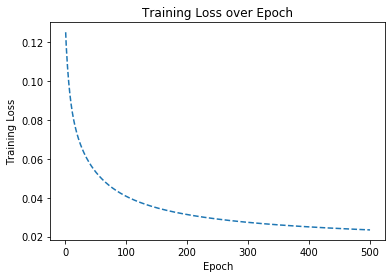

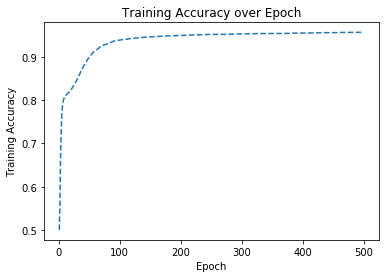

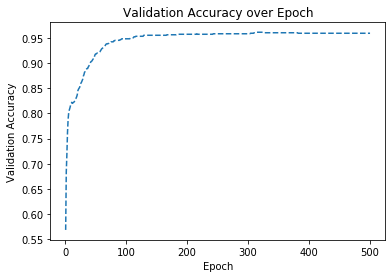

Training accuracy on epoch 314 = 0.9539166666666666
Validation accuracy on epoch 314 = 0.961


In [241]:
import numpy as np
from matplotlib import pyplot as plt

# @dataclass
class LogisticRegression:
    w: np.array
    b: float
    learning_rate: float
    n_epochs: int
    
    def __init__(self, weight, bias, learning_rate, n_epochs):
        self.w = weight
        self.b = bias
        self.learning_rate = learning_rate
        self.n_epochs = n_epochs
    
    def activation_function_input(self, w: np.array, x: np.array) -> np.array:
        """
        Calculate the input of activation function.
        --------------------
        w: current weight, of shape (1, 784)
        x: input data, of shape (784, n=12000)
        --------------------
        return: the output prediction
        """
        
        return w@x + self.b
    
    def predict(self, x) -> np.array:
        """
        Calculate the output prediction.
        --------------------
        x: input data, of shape (784, n=12000)
        --------------------
        return: the output prediction
        """
        
        activation_function_input = self.activation_function_input(self.w, x)
        
        return sigmoid(activation_function_input)
    
    def gradient(self, x, y)-> (np.array, np.array):
        """
        Calculate the gradients: dw and db
        --------------------
        x: input data, of shape (784, n=12000)
        y: true label vector, of shape (1, n)
        --------------------
        return: derivatives of loss function: L with respect to weight: w and bias: b
        """
        n = max(y.shape)
        
        p = self.predict(x)
        
        dy_hat = p-y
        dz = dy_hat*p*(1-p)
        
        dw = np.dot(dz, x.T)/n
        db = np.sum(dz)/n
        
        return (dw, db)
    
    def mean_squared_loss(self, y, y_pred) -> np.array:
        """
        Calculate the mean squared error.
        --------------------
        y: true label vector, of shape (1, n)
        y_pred: predicted label vector, of shape (1, n)
        --------------------
        return: mean squared loss
        """
        n = max(y.shape)
        return (y-y_pred)**2/(2*n)
    
    def finite_differences(self, x, y, delta_h=1e-5):
        """
        Calculate the finite difference.
        --------------------
        gradients: Current set of gradients
        learning_rate: parameter to guide SGD step size
        --------------------
        return: finite difference
        """
        
        n = max(y.shape)
        
        dw = self.gradient(x, y)[0]
        db = self.gradient(x, y)[1]
        
        w_plus = np.copy(self.w)
        w_minus = np.copy(self.w) 
        
        b_plus = self.b
        b_minus = self.b
        
        w_plus += delta_h/2
        w_minus -= delta_h/2
        
        b_plus += delta_h/2
        b_minus -= delta_h/2
        
        y_hat_plus_w = sigmoid(w_plus @ x + self.b)
        y_hat_minus_w = sigmoid(w_minus @ x + self.b)
        
        y_hat_plus_b = sigmoid(self.w @ x + b_plus)
        y_hat_minus_b = sigmoid(self.w @ x + b_minus)
    
        
        loss_plus_w = self.mean_squared_loss(y, y_hat_plus_w)
        loss_minus_w =  self.mean_squared_loss(y, y_hat_minus_w)
        
        loss_plus_b = self.mean_squared_loss(y, y_hat_plus_b)
        loss_minus_b =  self.mean_squared_loss(y, y_hat_minus_b)
        
        fd_dw = (loss_plus_w - loss_minus_w)/(delta_h)
        fd_db = (loss_plus_b - loss_minus_b)/(delta_h)
        
        difference_w = np.sum(dw) - np.sum(fd_dw)
        difference_b = np.sum(db) - np.sum(fd_db)
        
        return (difference_w, difference_b)
    
    def train(self, x, y, x_dev, y_dev, bound):
        # count the number of validation loss increments
        counter = 0
        
        losses = []
        training_accuracies = []
        validation_accuracies = []
        
        for i in range(self.n_epochs):
            y_hat = self.predict(x)
#             print(y_hat)
            dw, db = self.gradient(x, y)
            self.w = gradient_update(self.w, self.learning_rate, dw)
            self.b = gradient_update(self.b, self.learning_rate, db)
            
            training_loss = np.sum(self.mean_squared_loss(y, y_hat))
            losses.append(training_loss)
            
            training_accuracy = self.accuracy(y, np.where(y_hat >= 0.5, 1.0, 0.0))
            training_accuracies.append(training_accuracy)
            
            y_dev_hat = self.predict(x_dev)
            
            validation_accuracy = self.accuracy(y_dev, np.where(y_dev_hat >= 0.5, 1.0, 0.0))
            validation_accuracies.append(validation_accuracy)
            
            validation_loss = np.sum(self.mean_squared_loss(y_dev, y_dev_hat))
            
            if i > 0 and validation_loss > prev_validation_loss:
                counter += 1
            
            if counter == bound:
                print("reached bound")
                break
            
            prev_validation_loss = validation_loss
        
#         plot_loss("loss.png", losses)
#         print(accuracies)
#         plot_loss("accuracy.png", accuracies, label='Training Accuracy')
        return (losses, training_accuracies, validation_accuracies)
    
    def accuracy(self, y, y_hat):
        n = max(y_hat.shape)
        correct = np.sum(np.where(y == y_hat, 1.0, 0.0))
#         correct = np.sum(y_hat >= 0.5)
        return correct/n
    
    def plot(self, y_values, xlabel, ylabel, title):
        epochs = range(1, self.n_epochs+1)

        plt.figure()
        plt.plot(epochs, y_values, linestyle='--')
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title(title)
        plt.show()

p = LogisticRegression(np.zeros((x_train_flattened.shape[0], )), 0, 0.1, 500)
print(p.finite_differences(x_train_flattened, y_train))
losses, training_accuracies, validation_accuracies = p.train(x_train_flattened, y_train, x_dev_flattened, y_dev, 5)
p.plot(losses, 'Epoch', 'Training Loss', 'Training Loss over Epoch')
p.plot(training_accuracies, 'Epoch', 'Training Accuracy', 'Training Accuracy over Epoch')
p.plot(validation_accuracies, 'Epoch', 'Validation Accuracy', 'Validation Accuracy over Epoch')

# training_epoch = np.argmax(training_accuracies)
validation_epoch = np.argmax(validation_accuracies)
print("Training accuracy on epoch {} = {}".format(validation_epoch+1, training_accuracies[validation_epoch]))
print("Validation accuracy on epoch {} = {}".format(validation_epoch+1, validation_accuracies[validation_epoch]))